# Time series forecasing for network traffic dataset

In this notebook, we will show how to use Analytics Zoo to do time series forecasting.

The dataset we use is the aggregated network traffic traces at the transit link of WIDE to the upstream ISP (You can find the data [here](http://mawi.wide.ad.jp/~agurim/dataset/)). We use its monthly aggregated data of year 2018 and 2019 to do time series forecasting. The monthly aggregated data is collected at 2-hour interval.

To download data, you can run `get_data.sh`. It will download all the monthly aggregated data of 2018 and 2019 into `data`. 

The raw data contains full network traffic logs. To extract values which can indicate network traffic status (eg. `AvgRate` and `total`), you can run `extract_data.sh`. It will extract the useful values into data.csv in your `data` folder. 

## Helper functions

In [1]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
    df = df.reindex(full_idx)
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [2]:
def rm_missing_weeks(start_dts, missing_lens, df):
    # drop weeks that contains more than 3 consecutive missing values.
    # If consecutive missing values across weeks, we remove all the weeks.
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
def gen_dataset_matrix(dataset, look_back, target_col_indexes):
    X, Y = [], []
    if len(target_col_indexes) == 1:
        del_col_index = {0, 1}.difference(set(target_col_indexes)).pop()
        data = np.delete(dataset, del_col_index, axis=1)
    else:
        data = dataset
    for i in range(len(data)-look_back-1):
        X.append(data[i: (i + look_back)])
        Y.append(data[i + look_back, target_col_indexes])
    return np.array(X), np.array(Y)

In [4]:
def unscale(scaler, y, target_col_indexes):
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros((y.shape[0], dummy_feature_shape))
    y_dummy[:, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:,target_col_indexes]
    return y_unscale

In [5]:
EPSILON = 1e-10
def sMAPE(y_true, y_pred):
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    return np.mean(output_errors)

In [6]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    # plot the predicted values and actual values (for the test data)
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred,color='red', label='predicted values')
    axs.plot(date, y_test,color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Read raw dataset 

In [7]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
raw_df = pd.read_csv("data/data.csv")

In [9]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Data pre-processing should contain the below steps:  
1. Convert string datetime to TimeStamp
2. Unify `AvgRate` value since it contains different scales
3. Drop missing data and fill.

In [10]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [11]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [12]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [13]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [14]:
df.head()

,AvgRate,total
StartTime,,
2018-01-01 00:00:00,306.23,275605455598
2018-01-01 02:00:00,285.03,256527692256
2018-01-01 04:00:00,247.39,222652190823
2018-01-01 06:00:00,211.55,190396029658
2018-01-01 08:00:00,234.82,211340468977


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [15]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [16]:
df.ffill(inplace=True)

Visualization  
Note that we remove weeks from 2018-02-12 to 2018-03-11.

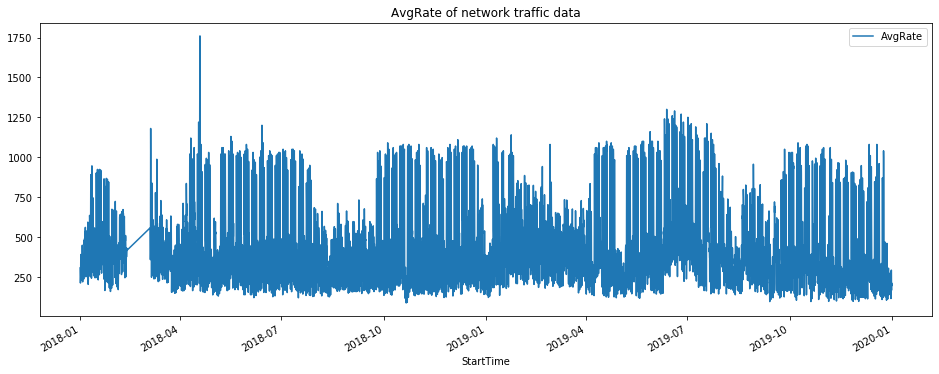

In [17]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

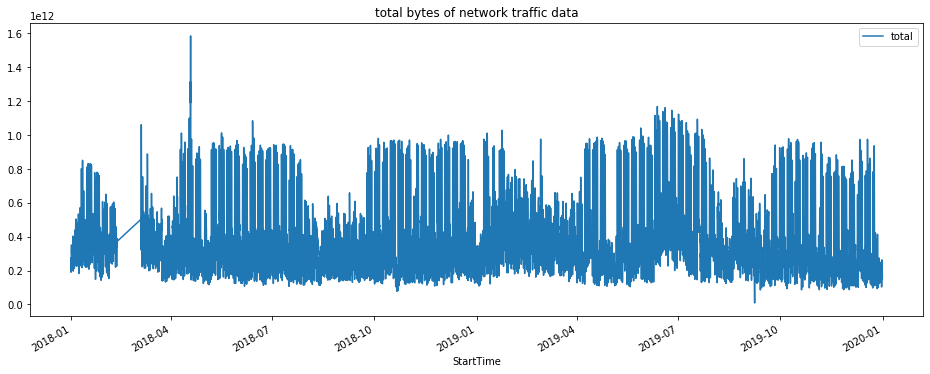

In [18]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering

Extract some useful datetime features.

In [19]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["dayofweek"] = df.index.dayofweek
df["hour"] = df.index.hour

In [20]:
df.head()

,AvgRate,total,year,month,week,dayofweek,hour
StartTime,,,,,,,
2018-01-01 00:00:00,306.23,275605455598,2018,1,1,0,0
2018-01-01 02:00:00,285.03,256527692256,2018,1,1,0,2
2018-01-01 04:00:00,247.39,222652190823,2018,1,1,0,4
2018-01-01 06:00:00,211.55,190396029658,2018,1,1,0,6
2018-01-01 08:00:00,234.82,211340468977,2018,1,1,0,8


## Data preparation

First, split dataset into train and test set

In [21]:
test_num = 1000
# we look back one week data which is of the frequency of 2h.
look_back = 84
test_split_index = test_num + look_back + 1
future_seq_len = 1

#train_df
train_df = df[:-test_num]
test_df = df[-test_split_index:]
test_df = test_df.reset_index(drop=True)

Then standardize train, test data and featues

In [22]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate data matrix by sliding window along time axis


In [23]:
# for univeriate
# here we take "AvgRate" as an example
uni_target_col_indexes = [0]
uni_target_value = "AvgRate"

x_train, y_train = gen_dataset_matrix(scaled_train, look_back, uni_target_col_indexes)
x_test, y_test = gen_dataset_matrix(scaled_test, look_back, uni_target_col_indexes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7423, 84, 6), (7423, 1), (1000, 84, 6), (1000, 1))

In [24]:
# for multivariate
multi_target_col_indexes = [0, 1]
multi_target_value = ["AvgRate","total"]

x_train_m, y_train_m = gen_dataset_matrix(scaled_train, look_back, multi_target_col_indexes)
x_test_m, y_test_m = gen_dataset_matrix(scaled_test, look_back, multi_target_col_indexes)
x_train_m.shape, y_train_m.shape, x_test_m.shape, y_test_m.shape

((7423, 84, 7), (7423, 2), (1000, 84, 7), (1000, 2))

# Time series forecasting 

### Univariate forecasting
We take LSTM model as an example.

In [27]:
from zoo.automl.model import VanillaLSTM
from zoo.tfpark import KerasModel

In [28]:
# build model
model = VanillaLSTM(future_seq_len=future_seq_len)._build(feature_num=x_train.shape[-1])

keras_model = KerasModel(model)

In [29]:
%%time
keras_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, distributed=False)

W0320 17:39:49.919517 4571913664 deprecation.py:323] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7423 samples
Epoch 1/10
7423/7423 [==============================] - 26s 3ms/sample - loss: 0.6782 - mean_squared_error: 0.6782
Epoch 2/10
7423/7423 [==============================] - 25s 3ms/sample - loss: 0.3114 - mean_squared_error: 0.3114
Epoch 3/10
7423/7423 [==============================] - 33s 4ms/sample - loss: 0.2232 - mean_squared_error: 0.2232
Epoch 4/10
7423/7423 [==============================] - 26s 4ms/sample - loss: 0.1868 - mean_squared_error: 0.1868
Epoch 5/10
7423/7423 [==============================] - 27s 4ms/sample - loss: 0.1682 - mean_squared_error: 0.1682
Epoch 6/10
7423/7423 [==============================] - 26s 4ms/sample - loss: 0.1571 - mean_squared_error: 0.1571
Epoch 7/10
7423/7423 [==============================] - 25s 3ms/sample - loss: 0.1501 - mean_squared_error: 0.1501
Epoch 8/10
7423/7423 [==============================] - 30s 4ms/sample - loss: 0.1470 - mean_squared_error: 0.1470
Epoch 9/10
7423/7423 [==============================] - 24

In [30]:
# make prediction
y_pred = keras_model.predict(x_test)

In [31]:
y_pred_unscale = unscale(standard_scaler, y_pred, uni_target_col_indexes)
y_test_unscale = unscale(standard_scaler, y_test, uni_target_col_indexes)

In [32]:
# evaluate with sMAPE
sMAPE(y_test_unscale, y_pred_unscale)

8.151631946694321

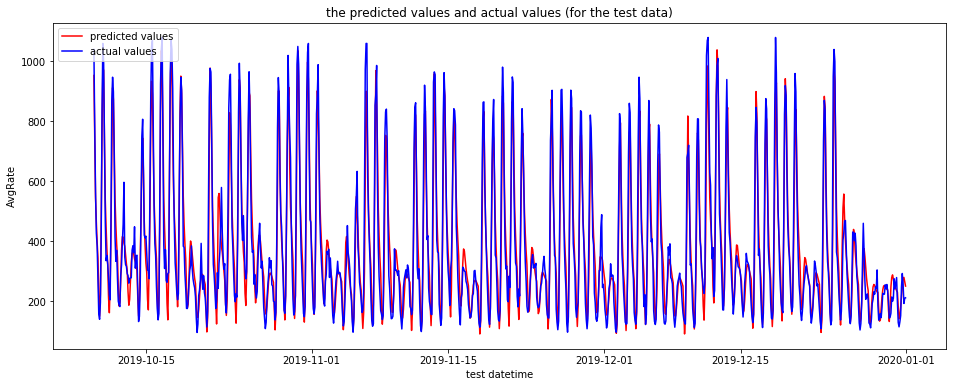

In [33]:
test_date=df[-test_num:].index
plot_predict_actual_values(test_date, y_pred_unscale, y_test_unscale, ylabel=uni_target_value)


### multivariate forecasting 

We use MTNet model as an example for multivariate forecasting.

In [34]:
from zoo.automl.model import MTNetKeras

In [35]:
mtnet_configs = {
    "long_num": 6,
    "time_step": 12,
    "cnn_height": 2,
    "ar_window": 2,
    "feature_num": x_train_m.shape[-1],
    "output_dim": y_train_m.shape[-1]
}

In [36]:
mtnet = MTNetKeras()
mtnet.apply_config(config=mtnet_configs)

In [37]:
%%time
mtnet_model = mtnet.build()
keras_mtnet_model = KerasModel(mtnet_model)

W0320 17:44:20.338207 4571913664 deprecation.py:506] From /Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:94: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/Users/yushan/anaconda3/envs/automl_ut/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPU times: user 21.3 s, sys: 845 ms, total: 22.2 s
Wall time: 23.9 s


In [38]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet._reshape_input_x(x_train_m)
x_test_mtnet = mtnet._reshape_input_x(x_test_m)

In [39]:
%%time
hist = keras_mtnet_model.fit(x = x_train_mtnet, y = y_train, batch_size=1024, epochs=20)

Train on 7423 samples
Epoch 1/20
7423/7423 [==============================] - 47s 6ms/sample - loss: 0.8739 - mean_squared_error: 1.1561
Epoch 2/20
7423/7423 [==============================] - 25s 3ms/sample - loss: 0.8179 - mean_squared_error: 1.0573
Epoch 3/20
7423/7423 [==============================] - 22s 3ms/sample - loss: 0.7647 - mean_squared_error: 0.9955
Epoch 4/20
7423/7423 [==============================] - 20s 3ms/sample - loss: 0.7257 - mean_squared_error: 0.9562
Epoch 5/20
7423/7423 [==============================] - 26s 3ms/sample - loss: 0.6769 - mean_squared_error: 0.8347
Epoch 6/20
7423/7423 [==============================] - 21s 3ms/sample - loss: 0.6097 - mean_squared_error: 0.7265
Epoch 7/20
7423/7423 [==============================] - 23s 3ms/sample - loss: 0.5413 - mean_squared_error: 0.6049
Epoch 8/20
7423/7423 [==============================] - 23s 3ms/sample - loss: 0.4933 - mean_squared_error: 0.5136
Epoch 9/20
7423/7423 [==============================] - 22

In [40]:
y_pred_m = keras_mtnet_model.predict(x_test_mtnet)

In [41]:
y_pred_m_unscale = unscale(standard_scaler, y_pred_m, multi_target_col_indexes)
y_test_m_unscale = unscale(standard_scaler, y_test_m, multi_target_col_indexes)

In [42]:
# evaluate with sMAPE
sMAPE(y_pred_m_unscale, y_test_m_unscale)

9.44295981310106

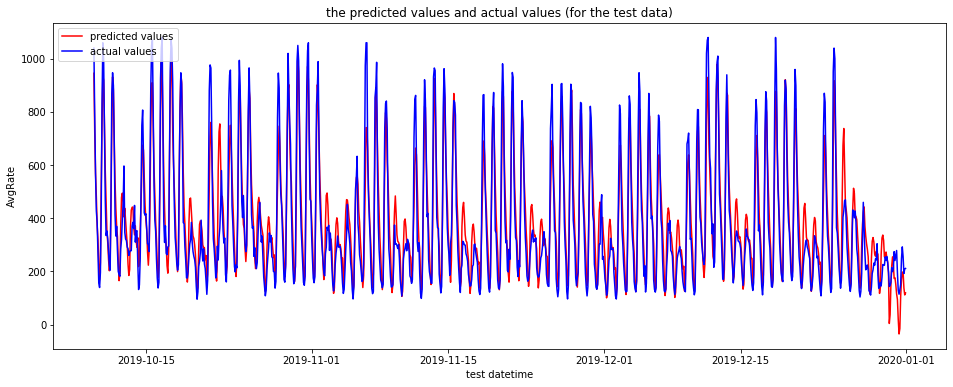

In [43]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,0], y_test_m_unscale[:,0], ylabel=multi_target_value[0])

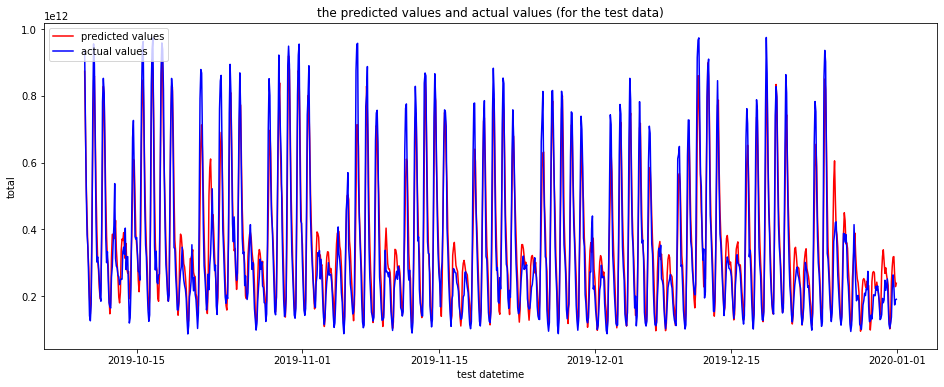

In [44]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,1], y_test_m_unscale[:,1], ylabel=multi_target_value[1])